In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.applications import ResNet50V2

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
class WeedDetectionModel:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.img_height = 160  # Reduced image size
        self.img_width = 160   # Reduced image size
        self.batch_size = 32
        self.epochs = 20       # Reduced epochs
        self.model = None
        self.class_labels = None
        self.history = None

    def prepare_data(self):
        # Create data generator with basic augmentation
        datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=0.2,
            rotation_range=20,
            horizontal_flip=True
        )

        # Load training data
        try:
            self.train_generator = datagen.flow_from_directory(
                self.data_dir,
                target_size=(self.img_height, self.img_width),
                batch_size=self.batch_size,
                class_mode='categorical',
                subset='training'
            )

            # Load validation data
            self.validation_generator = datagen.flow_from_directory(
                self.data_dir,
                target_size=(self.img_height, self.img_width),
                batch_size=self.batch_size,
                class_mode='categorical',
                subset='validation'
            )

            self.class_labels = self.train_generator.class_indices
            print("Classes found:", self.class_labels)

        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise

    def build_model(self):
        try:
            # Load pre-trained MobileNetV2 (lighter than ResNet)
            base_model = MobileNetV2(
                weights='imagenet',
                include_top=False,
                input_shape=(self.img_height, self.img_width, 3)
            )

            # Freeze base model
            base_model.trainable = False

            # Add custom layers
            x = base_model.output
            x = GlobalAveragePooling2D()(x)
            x = Dense(128, activation='relu')(x)
            x = Dropout(0.5)(x)
            predictions = Dense(len(self.class_labels), activation='softmax')(x)

            self.model = Model(inputs=base_model.input, outputs=predictions)

        except Exception as e:
            print(f"Error building model: {str(e)}")
            raise

    def train_model(self):
        try:
            # Compile model
            self.model.compile(
                optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )

            # Early stopping callback
            early_stopping = EarlyStopping(
                monitor='val_loss',
                patience=3,
                restore_best_weights=True
            )

            # Train model
            self.history = self.model.fit(
                self.train_generator,
                epochs=self.epochs,
                validation_data=self.validation_generator,
                callbacks=[early_stopping]
            )

        except Exception as e:
            print(f"Error training model: {str(e)}")
            raise

    def save_model(self, filepath):
        try:
            self.model.save(filepath)
            print(f"Model saved successfully to {filepath}")
        except Exception as e:
            print(f"Error saving model: {str(e)}")
            raise

    def predict_image(self, image_path):
        try:
            # Load and preprocess image
            img = tf.keras.preprocessing.image.load_img(
                image_path,
                target_size=(self.img_height, self.img_width)
            )
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = img_array / 255.0

            # Make prediction
            predictions = self.model.predict(img_array)
            predicted_class = list(self.class_labels.keys())[np.argmax(predictions[0])]
            confidence = float(np.max(predictions[0]) * 100)

            return {
                'class': predicted_class,
                'confidence': confidence
            }

        except Exception as e:
            print(f"Error making prediction: {str(e)}")
            raise

In [ ]:
from tensorflow.keras.applications import MobileNetV2

In [ ]:
def main():
    try:
        # Set your data directory
        data_dir = '/content/drive/MyDrive/unzipped_dataset/dataset'  # Replace with your dataset path

        # Initialize model
        print("Initializing model...")
        model = WeedDetectionModel(data_dir)

        # Prepare data
        print("Preparing data...")
        model.prepare_data()

        # Build model
        print("Building model...")
        model.build_model()

        # Train model
        print("Training model...")
        model.train_model()

        # Save model
        print("Saving model...")
        model.save_model('weed_detection_model.h5')

        # Example prediction
        print("\n Making a test prediction...")
        test_image = '/content/soybean-plant-2 (1).jpeg'  # Replace with your test image path
        result = model.predict_image(test_image)
        print(f"Predicted class: {result['class']}")
        print(f"Confidence: {result['confidence']:.2f}%")

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

Initializing model...
Preparing data...
Found 12270 images belonging to 4 classes.
Found 3066 images belonging to 4 classes.
Classes found: {'broadleaf': 0, 'grass': 1, 'soil': 2, 'soybean': 3}
Building model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training model...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


384/384 ━━━━━━━━━━━━━━━━━━━━ 5855s 15s/step - accuracy: 0.9236 - loss: 0.2249 - val_accuracy: 0.9873 - val_loss: 0.0374
Epoch 2/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 556s 1s/step - accuracy: 0.9810 - loss: 0.0587 - val_accuracy: 0.9909 - val_loss: 0.0270
Epoch 3/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 505s 1s/step - accuracy: 0.9841 - loss: 0.0474 - val_accuracy: 0.9912 - val_loss: 0.0236
Epoch 4/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 554s 1s/step - accuracy: 0.9818 - loss: 0.0501 - val_accuracy: 0.9918 - val_loss: 0.0195
Epoch 5/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 499s 1s/step - accuracy: 0.9856 - loss: 0.0437 - val_accuracy: 0.9922 - val_loss: 0.0196
Epoch 6/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 560s 1s/step - accuracy: 0.9876 - loss: 0.0365 - val_accuracy: 0.9938 - val_loss: 0.0161
Epoch 7/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 518s 1s/step - accuracy: 0.9877 - loss: 0.0356 - val_accuracy: 0.9909 - val_loss: 0.0252
Epoch 8/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 556s 1s/step - accuracy: 0.9867 - loss: 0.0387 - val_accuracy: 0.9

Saving model...
Model saved successfully to weed_detection_model.h5

 Making a test prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: soybean
Confidence: 60.68%


In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.models.load_model('/content/weed_detection_model (1).h5')

In [ ]:

import numpy as np
import matplotlib.pyplot as plt


# Define the image size that matches the model's expected input
img_height, img_width = 160, 160

# Function to predict category of an input image, display the image, and show weed detection result
def predict_image_category(image_path):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict using the loaded model
    prediction = model.predict(img_array)

    # Map predictions to category labels
    class_indices = {'soil': 0, 'weed': 1, 'grass': 2, 'soybean': 3}  # Replace with actual class order if different
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[np.argmax(prediction)]
    confidence = np.max(prediction)  # Confidence score for the predicted class

    # Display the image
    plt.figure(figsize=(6, 6))
    img_display = tf.keras.preprocessing.image.load_img(image_path)
    plt.imshow(img_display)
    plt.axis('off')

    # Print and display result based on prediction
    if predicted_class == 'weed':
        plt.title("Weed Detected")
        print("Weed Detected")
    else:
        plt.title("No Weed Detected")
        print("No Weed Detected")

    plt.show()

    return predicted_class, confidence



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Weed Detected


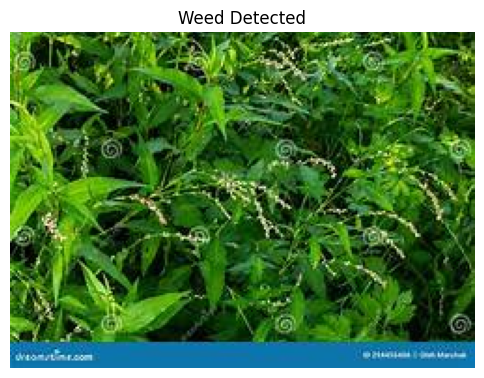

Confidence: 0.97%


In [ ]:
image_path = '/content/78b49c33-0c90-4b9f-8ff9-e5a6dfb2652f.jpg'
predicted_class, confidence = predict_image_category(image_path)
print(f"Confidence: {confidence:.2f}%")